In [ ]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0d84671d339e671b9ebcf79c3b2a7560342e91ec5b33a9215161b23e08bca539
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=b4a30845079fc24ba9b3a3287ed5a3c7ee622a68c0460a58af0e6aed99174e02
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim

import segmentation_models_pytorch as smp

In [ ]:
!unzip -q /content/drive/MyDrive/makeup-lips-segmentation-28k-samples.zip

In [ ]:
DATASET_FILEPATH = Path('/content/set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [ ]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [ ]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [ ]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [ ]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

In [ ]:
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [ ]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [ ]:
IMG_SIZE = 256

In [ ]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):

    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))

    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)

    return resized_image, resized_mask

class LipsDataset(torch.utils.data.Dataset):

    def __init__(self, data, preprocessing=None):

        self.data = data
        self.preprocessing = preprocessing

        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]

        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):

        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]

        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)

        img = img.astype(float)

        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0

        img = img.permute(2, 0, 1)

        cls_mask_1 = mask[..., 1]

        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]

        cls_mask_1 = cls_mask_1.astype('float')

        masks = [cls_mask_1]

        masks = torch.as_tensor(masks, dtype=torch.float)


        return img.float(), masks

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
BACKBONE = 'resnet34'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 122MB/s]


In [ ]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.2,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

<ipython-input-13-d3b12a3fdee2>:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  masks = torch.as_tensor(masks, dtype=torch.float)


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)
torch.Size([8, 1, 256, 256])


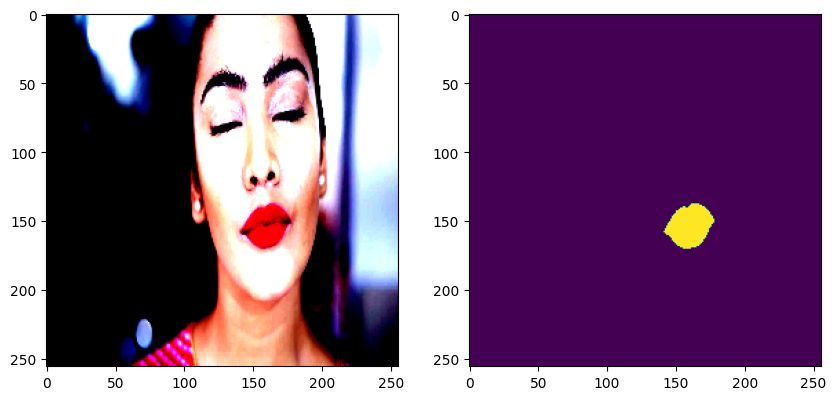

In [ ]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    print(masks.shape)
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [ ]:
import segmentation_models_pytorch.utils

criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    device=device,
    verbose=True
)

In [ ]:
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, '/content/drive/MyDrive/model_2eps.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 1427/1427 [03:18<00:00,  7.18it/s, bce_loss - 0.000918, iou_score - 0.9264]
Model saved!


In [ ]:
data_iter = iter(train_loader)

In [ ]:

for images, labels in train_loader:
#    outputs = segmodel(images)
#      images, labels = data_iter.next()
      images, labels = images.to(device), labels.to(device)
      outputs = segmodel(images)


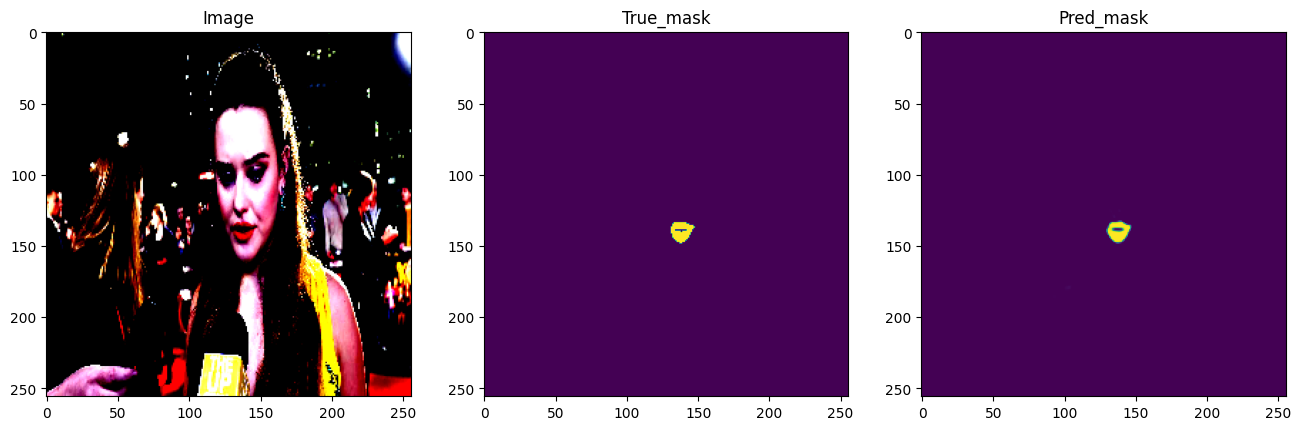

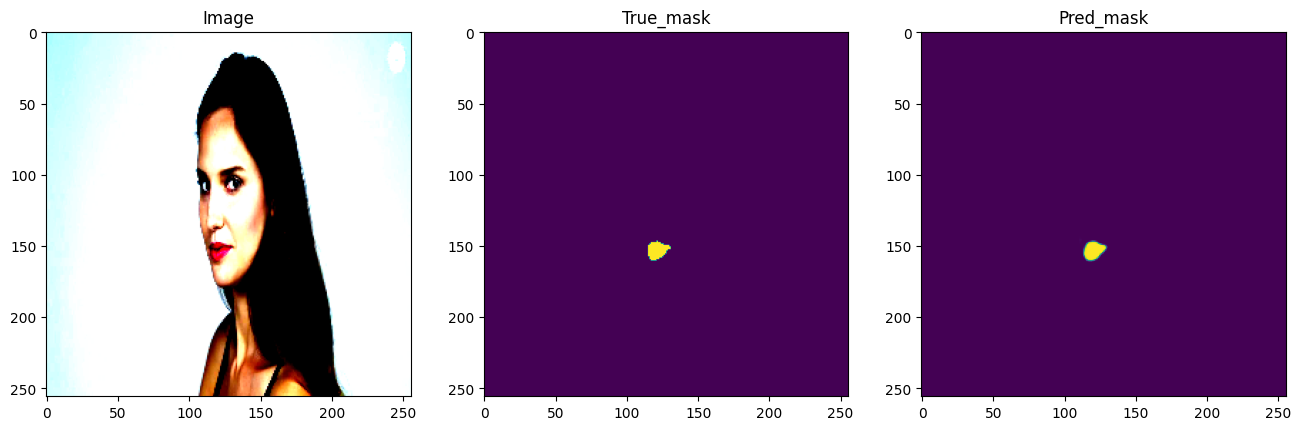

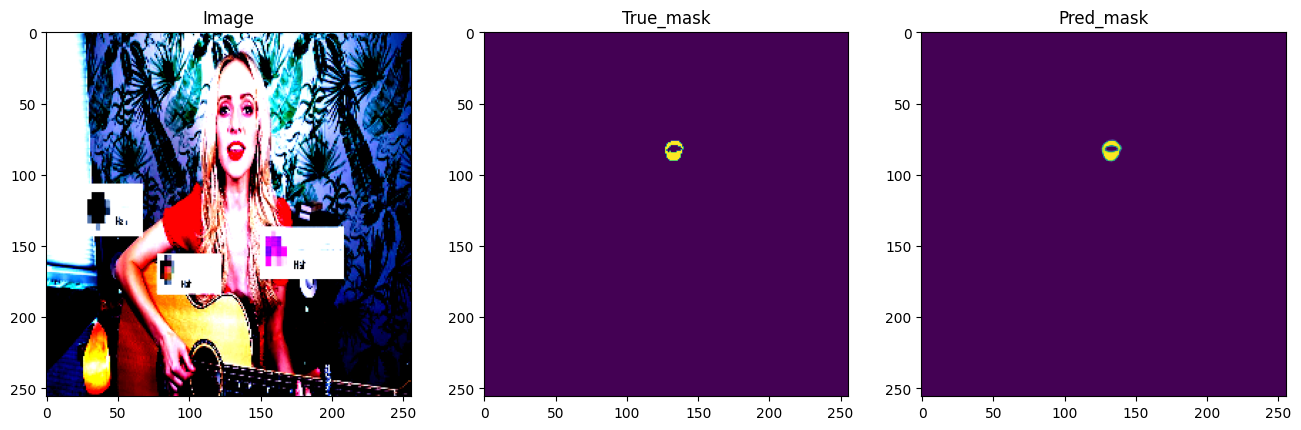

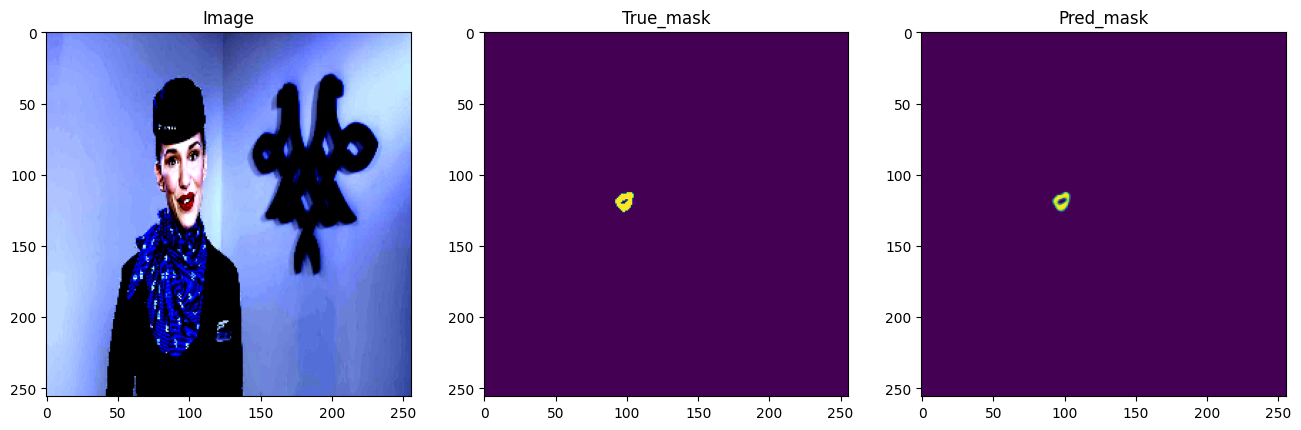

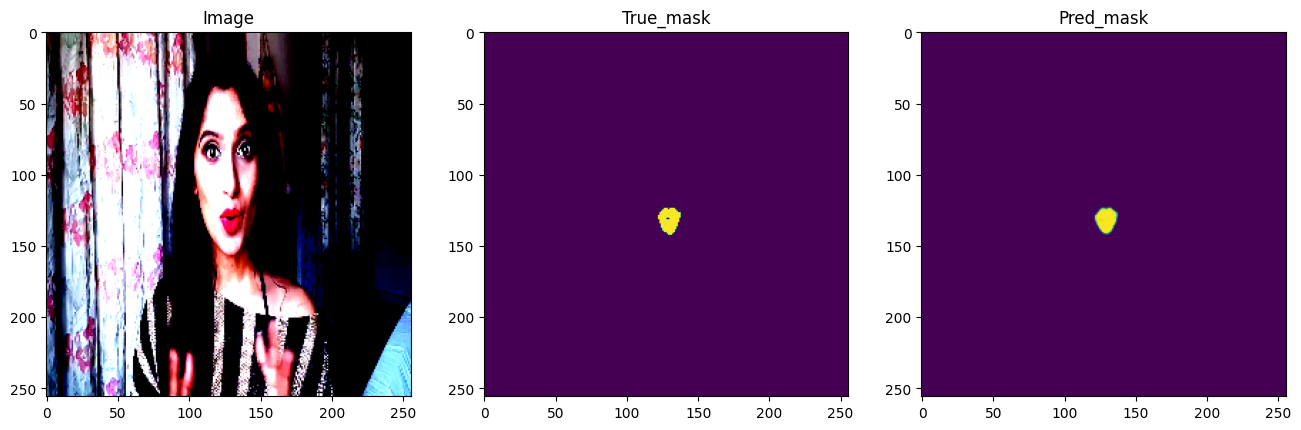

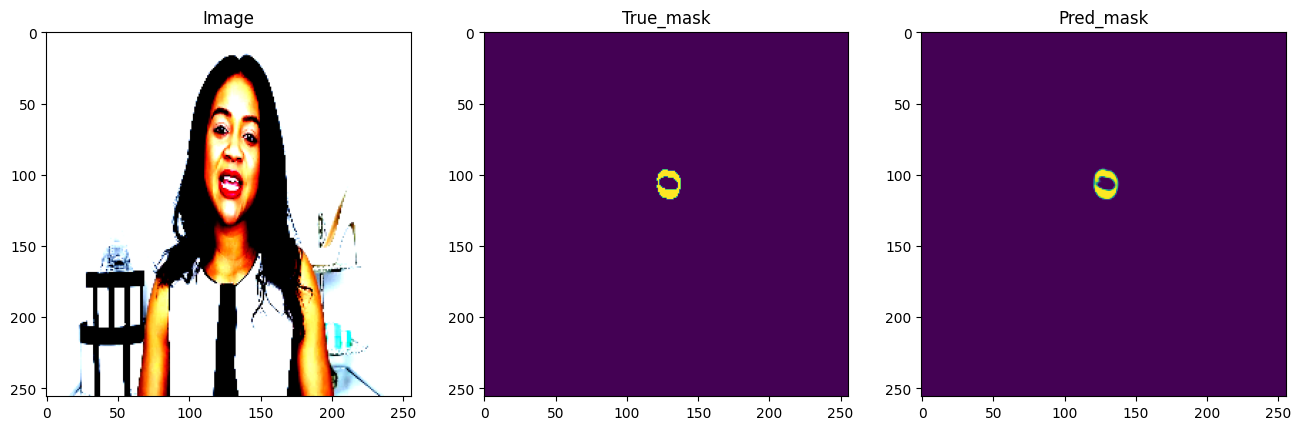

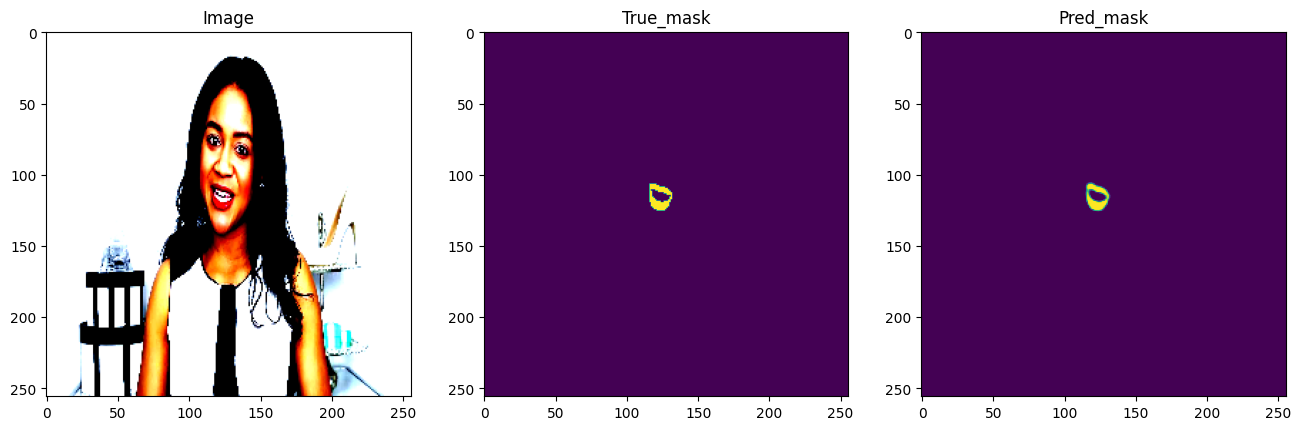

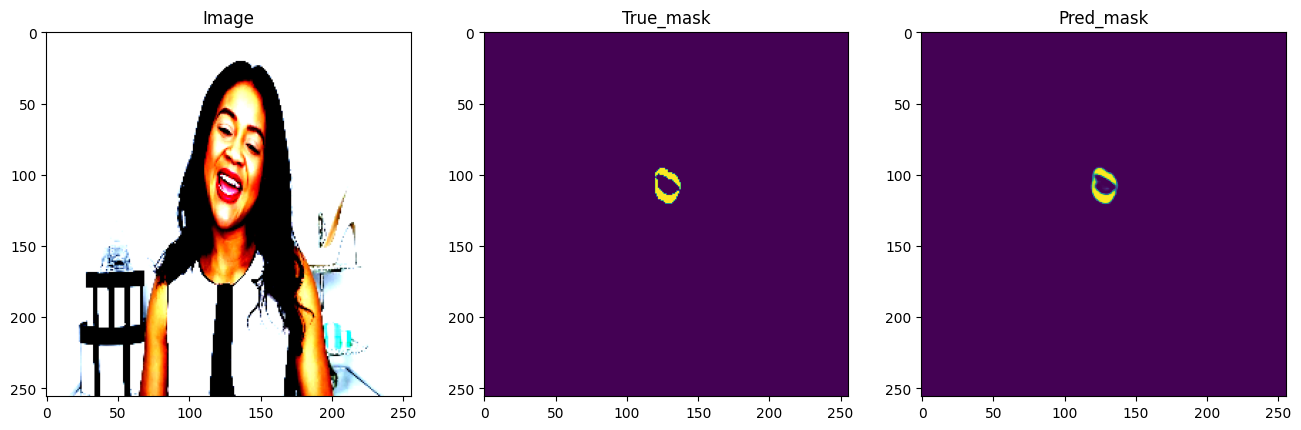

In [ ]:
for i in range(images.shape[0]):

    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))

    image = images[i].permute(1, 2, 0)

    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')

    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')

    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')

In [ ]:
def predict(image_path, model, preprocess_input, device):
    # Đọc ảnh đầu vào
    image = cv2.imread(image_path)
    # Tiền xử lý ảnh
    image = cv2.cvtColor(cv2.resize(image, (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB)
    image = image.astype(float)

    # Áp dụng preprocessing
    image = preprocess_input(image)
    image = torch.as_tensor(image)
    image /= 255.0

    image = image.permute(2, 0, 1).unsqueeze(0).to(device)

    # Dự đoán với mô hình
    model.eval()  # Chuyển mô hình về chế độ inference
    with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
        output = model(image)

    # Chuyển đổi đầu ra (output) từ tensor thành ảnh
    output = output.squeeze().cpu().numpy()
    output = (output > 0.5).astype(np.uint8)  # Áp dụng ngưỡng để chuyển đổi thành nhị phân (0 hoặc 1)

    return output